# Gaussian Process Regression for Astronomy
#### Brett Morris, Python in Astronomy 2020

Requirements for presentation: 
```
conda install -c conda-forge rise
```
Don't forget: to enable scrolling in presentation view, click on the NbExtensions tab on the Jupyter Home page, select RISE, and enable scrolling by toggling the `scroll` option

# *The* GP Reference

The purpose of this tutorial is to introduce the concepts of Gaussian process regression, and give users an interactive environment for experimenting with Gaussian processes. This tutorial is based on [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/), but is designed to be more readable and to encourage experimentation!

### Getting started


Let's generate some fake, one dimensional data, which we'll fit with various techniques.

First we need to import matplotlib, numpy, scipy for this notebook:

In [57]:
# Display utilities 
%matplotlib inline
from IPython.display import display
from ipywidgets import interactive
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

# Import the standard Python science stack:
import numpy as np
from scipy.optimize import minimize

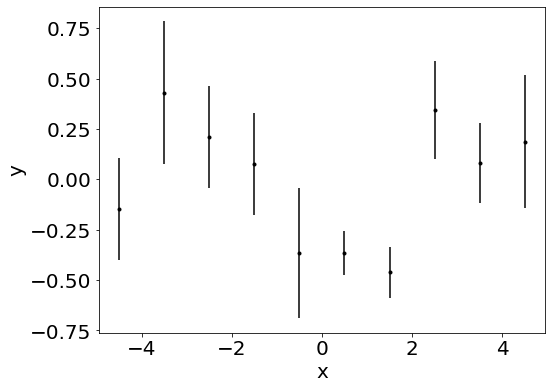

In [58]:
np.random.seed(42)
ndim = 10

# We want our `x` and `y` vectors to be column vectors, so we'll use 
# the [:, np.newaxis] shorthand to turn rows into columns
y = np.random.rand(ndim)[:, None]
y -= y.mean()
x = np.arange(len(y), dtype=float)[:, None]
x -= x.mean()
yerr = (y.std() + 0.1*np.random.randn(len(x))) 

# Plot the observations:
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.xlabel('x')
plt.ylabel('y');

# Linear regression

Solutions to the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimators $\hat{\beta}$ are

$$ \hat{\beta} = ({\bf X}^\top {\bf N}^{-1} {\bf X})^{-1} {\bf X}^\top {\bf N}^{-1} y,$$

and their uncertainties are given by

$$ \mathrm{cov} = {\bf X}^\top {\bf N}^{-1} {\bf X}, $$

where ${\bf N} = \sigma_n^2 {\bf I}$ is the matrix of variances $\sigma_n^2$ on measurements $y$.

Let's implement this using numpy! Note: the `@` operator can be used in python>3.5 to multiply matrices together.

In [59]:
# Append a column of ones next to the `x` values using `np.vander`: 
X = np.vander(x.ravel(), 2)
inv_N = np.linalg.inv(np.identity(len(x)) * yerr**2)

# Solve linear regression: 
betas = np.linalg.inv(X.T @ inv_N @ X) @ X.T @ inv_N @ y
cov = np.linalg.inv(X.T @ inv_N @ X)

# Compute best-fit line: 
best_fit = X @ betas 
errors = np.sqrt(np.diag(cov))

print(f"beta = {betas}")
print(f"err = {errors}")

beta = [[-0.01066847]
 [-0.17601376]]
err = [0.02845507 0.06356835]


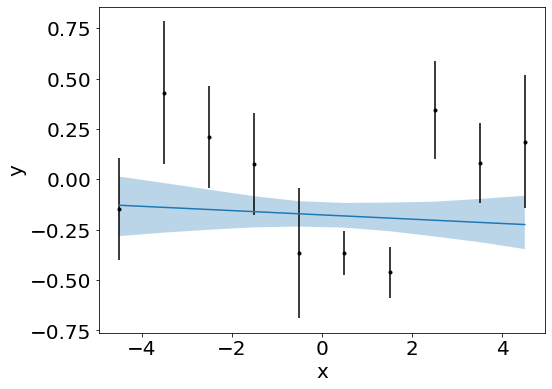

In [60]:
# compute upper and lower limits on the confidence interval

m, b = betas
m_err, b_err = errors
n = 1000
samples = (b + b_err * np.random.randn(1, n) + 
           x * (m + m_err * np.random.randn(1, n)))
lower_env, upper_env = np.percentile(samples, [16, 84], axis=1)

# Plot the result
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.plot(x, best_fit)
plt.fill_between(x[:, 0], lower_env, upper_env, 
                 alpha=0.3)
plt.xlabel('x')
plt.ylabel('y');


# Gaussian process regression

Gaussian process regression, in this example, is a technique for interpolating between observations or predicting the values of observations at a given time. The linear algebra this time looks a little more complicated, but it's a similar process:   

We define a "**covariance function**" or "**kernel function**"

$$ {\bf K}({\bf x_1}, {\bf x_2}) = \exp\left(-\frac{(x_1 - x_2)^2}{2 \ell^2}\right)   $$

A **kernel function** describes the correlation between neighboring points. To start, we're using "squared exponential" kernel, which equivalent to saying "the correlation between neighboring points is defined by a Gaussian with one parameter: $\ell$." We call the tunable parameters within the kernel function **hyperparameters**. Don't let the fancy name intimidate you – all hyperparameters do is define the kernel function, which describes how correlated neighboring points are. 

##### The $\ell$ hyperparameter 

The $\ell$ parameter sets the autocorrelation timescale, in other words, how far two points need to be from each other in $x$ (time) before they are no longer correlated. If $\ell$ is large, distant points become more correlated, or in other words, the function becomes smoother. If $\ell$ is small, the function varies more rapidly with $x$. 

### Predicting observations at arbitrary $x$

Let's say that we've taken observations at times ${\bf x}$ and we'd like to predict unobserved values of $y$ at new times ${\bf x_\star}$. ${\bf I}$ is the identity matrix, and $\sigma_n$ is the uncertainty on each measurement `y`. The predictive mean is (Equation 2.25 of [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/)) 

$$ \mu_* = {\bf K(x, x_*)}^\top ({\bf K(x, x)} + \sigma_n^2 {\bf I})^{-1} {\bf y},  $$

and the covariance is (Equation 2.26)

$$ \mathrm{cov} = {\bf K}({\bf x_*}, {\bf x_*})- {\bf K(x, x_*)}^\top ({\bf K(x, x)}+ \sigma_n^2 {\bf I})^{-1} {\bf K(x, x_*)}, $$ 

and thus the uncertainty on the $\mu_*$ predictions are given by

$$ \mathrm{err} = \sqrt{\mathrm{diag}\left( \mathrm{cov} \right)}$$ 

where the $\textrm{diag}$ operator extracts the diagonal of a matrix. 

We also get the log marginal likelihood by computing: 

$$ \ln p({\bf y} | X) = -\frac{1}{2} {\bf y}^\top ({\bf K(x, x)} + \sigma_n^2 {\bf I})^{-1} {\bf y} - \frac{1}{2}\log{ \left|{\bf K(x, x)} + \sigma_n^2 {\bf I}\right|} - \frac{n}{2}\log{2\pi} $$

We can implement this in just a few lines of Python:

Let's define some utility functions: 

In [61]:
def square_distance(x1, x2): 
    """
    Compute the squared distance between two vectors `x1` and `x2`, which
    need not have the same shape. 
    
    Note that (x1 - x2)^2 = x1^2 + x2^2 - 2 * x1 * x2, so we can use terse
    (and rather opaque) numpy syntax implemented here to avoid loops. 
    
    Parameters
    ----------
    x1 : `~numpy.ndarray`
        Positions with shape (M, 1)
    x2 : `~numpy.ndarray`
        Positions with shape (N, 1)
    
    Returns 
    -------
    d : `~numpy.ndarray`
        Distances between each position with shape (M, N)
    """
    ## The code after `return` is shorthand for the 
    ## following routine, but much faster:
    # result = np.zeros((len(x1), len(x2)))
    # for i in range(len(x1)): 
    #     for j in range(len(x2)):
    #         result[i, j] = (x1[i] - x2[j])**2
    
    return (np.sum(x1**2, axis=1)[:, None] + 
            np.sum(x2**2, axis=1) - 2 * x1 @ x2.T)
            

In [62]:
def sq_exp_kernel(x1, x2, ell=1): 
    """
    Squared-exponential kernel function
    
    Parameters
    ----------
    x1 : `~numpy.ndarray`
        Positions with shape (M, 1)
    x2 : `~numpy.ndarray`
        Positions with shape (N, 1)
        
    Returns
    -------
    k : `~numpy.ndarray`
        Covariance between `x1` and `x2`
    """
    sqdist = square_distance(x1, x2)

    return np.exp(-0.5 * sqdist / ell**2)

In [63]:
def gaussian_process_regression(x, y, yerr, xtest, kernel, **kwargs): 
    """
    Gaussian process regression for column vectors `x` and `y` with 
    uncertainties `yerr`; predict values at `xtest` using `kernel`.
    
    You may ignore the **kwargs trick we're using here, which will come 
    in handy later. 
    
    Parameters
    ----------
    x : `~numpy.ndarray`
        Times of observations (for example)
    y : `~numpy.ndarray`
        Observations made at each `x`
    yerr : `~numpy.ndarray`
        Uncertainties on the observations `y`
    xtest : `~numpy.ndarray`
        New times (for example) with the same units as `x` 
    kernel : function
        Kernel (covariance) function. 
    
    Returns
    -------
    mu : `~numpy.ndarray`
        Predictive mean of the  Gaussian processat new times `xtest`
    cov : `~numpy.ndarray`
        Predictive Gaussian process covariance matrix (which can 
        be used to compute uncertainties on `mu`) 
    lnlike : float
        Log marginal likelihood of the Gaussian process model
    """
    K = kernel(x, x, **kwargs) + yerr**2 * np.identity(len(x)) 
    K_s = kernel(x, xtest, **kwargs)
    K_ss = kernel(xtest, xtest, **kwargs)
    
    # Take the inverse only once, since this is the most expensive computation:
    inv_K = np.linalg.inv(K)
    
    # The `@` operator in python 3 is the matrix multiplication operator
    mu = K_s.T @ inv_K @ y
    cov = K_ss - K_s.T @ inv_K @ K_s
    
    # Compute the log likelihood
    lnlike = (-0.5 * y.T @ inv_K @ y - 0.5 * np.log(np.linalg.det(K)) - 
              len(x)/2 * np.log(2*np.pi))
    return mu, cov, lnlike

def gp_interact(error_scale):
    mu, cov, lnlike = gaussian_process_regression(x, y, yerr*error_scale, xtest, sq_exp_kernel)

    err = np.sqrt(np.diagonal(cov))

    plt.figure(figsize=(8, 6))
    plt.errorbar(x, y, yerr*error_scale, fmt='.', color='k')
    plt.plot(xtest.ravel(), mu.ravel(), label='GP mean')
    plt.fill_between(xtest.ravel(), mu.ravel()-err, mu.ravel()+err, 
                     alpha=0.3, label='GP uncertainty')
    plt.legend(loc='upper center')
    plt.xlabel('x')
    plt.ylabel('y');

In [64]:
# Let's call our Gaussian process regression method on our data, interpolating between the observations: 

N = 100
# Interpolate `N` observations from the minimum to maximum values of `x` 
xtest = np.linspace(x.min(), x.max(), N)[:, None]
    
# print('Vary the uncertainty with the scaling parameter "error_scale", gets multplied by the error in y:')
interactive_plot = interactive(gp_interact, error_scale=(0.1, 1, 0.1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='error_scale', max=1.0, min=0.1), Output()), _dom_cla…

In the figure above, the blue line shows the predicted value of $y$ for values of $x$ where there were no observations – that's why we say Gaussian process regression is a form of interpolation. It's essentially interpolating between points, where the smoothness of the interpolation is set by the kernel function. 

But Gaussian process regression is more powerful than just predicting the value of $y$ for arbitrary $x$, it also computes the *uncertainty* of the prediction for arbitrary $x$. The blue region in the figure above shows the uncertainty on the predicted value of $y$ at each $x$. Note that the uncertainty is roughly equivalent to the width of the error bars where there are observations, and the uncertainty gets larger in between observations. You can **change the uncertainties on each point** and see its effect on the uncertainty in the predictive mean by sliding the `error_scale` slider above the plot. As your observations shift towards higher precision (smaller uncetainties), so does the Gaussian process model.  

Gaussian process regression is often referred to as a form of **"non-parametric"** parameter estimation, which is a way of saying that you don't define the functional form of the mean, $\mu$. $\mu$ is not a polynomial function, it is not a trigonometric function, it is a highly adaptive interpolation function whose functional form is in fact defined by its covariance matrix (${\bf K}$), rather than being some function $\mu = f(x)$ (which means typically it's not easy to write the functional form of the GP in terms of $x$).

### Squared-Exponential (Gaussian) Kernel

Let's fit the data with an interactive kernel, which allows you to vary the $\ell$ hyperparameter and see the results: 

In [66]:
def gp_interact(ell):
    """
    The contents of this function will be interactive!
    """
    def sq_exp_kernel_interactive(x1, x2=None, ell=ell): 
        """
        Interactive Gaussian Kernel function
        """
        if x2 is not None: 
            sqdist = square_distance(x1, x2)
        else: 
            sqdist = x1**2
            
        return np.exp(-0.5 * sqdist / ell**2)
    
    mu, cov, lnlike = gaussian_process_regression(x, y, yerr, xtest, sq_exp_kernel_interactive)
    err = np.sqrt(np.diag(cov))
    
    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    ax[0].errorbar(x, y, yerr, fmt='.', color='k')
    ax[0].plot(xtest.ravel(), mu.ravel(), label='GP Mean')
    ax[0].fill_between(xtest.ravel(),  mu.ravel()-err, mu.ravel()+err, 
                       alpha=0.2, label='GP Uncertainty')
    ax[0].set(xlabel='$x$', ylabel='$y$', title='GP Regression')
    
    ax[1].set(xlabel='$x_1$', ylabel='$x_2$', title='Covariance matrix')
    ax[1].imshow(sq_exp_kernel_interactive(x, x))
    
    lags = np.linspace(0, 10)
    ax[2].plot(lags, sq_exp_kernel_interactive(lags))
    ax[2].set(xlabel='Lags', ylabel='Covariance', title='Autocorrelation Function')
    fig.tight_layout()
    plt.show()

print('Vary the hyperparameter "ell", which defines the autocorrelation timescale:')
interactive_plot = interactive(gp_interact, ell=(1, 10, 1))
output = interactive_plot.children[-1]
interactive_plot

Vary the hyperparameter "ell", which defines the autocorrelation timescale:


interactive(children=(IntSlider(value=5, description='ell', max=10, min=1), Output()), _dom_classes=('widget-i…

In the figure above, the left plot shows the mean model (blue) with its uncertainty (blue shaded region), and the data (black circles). 

The middle plot shows the covariance matrix – note that it's got most of its weight along the diagonal, which is a mathematical representation of saying "observations close in $x$ to one another are more correlated than observations far apart in $x$". The brightness of each pixel corresponds to the strength of the correlation between the two inputs $x_1$ and $x_2$. 

Alternatively, a simpler way to visualize the behavior of your kernel function is to plot the kernel function directly, which is shown on the right. Note how distant points (large lags) have stronger autocorrelation power when `ell` is large.